## Import libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Import And Preprocess Data Set

In [5]:
df = pd.read_csv("/content/drive/My Drive/Smith and Thopte CE397Proj/Temp/GlobalTemp.csv", sep=',', skiprows=5, header=None, low_memory=False)
# Rename columns to 'Date' and 'Value'
df.rename(columns={0: 'Date', 1: 'Value'}, inplace=True)
# Convert Effective date type to datetime
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[:4] + '-' + df['Date'].astype(str).str[4:], format='%Y-%m')

# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
print(df.head())

        Date  Value
0 1850-01-01  -0.46
1 1850-02-01  -0.22
2 1850-03-01  -0.22
3 1850-04-01  -0.36
4 1850-05-01  -0.30


In [6]:
# Read the first few lines of the raw file content
with open("/content/drive/My Drive/Smith and Thopte CE397Proj/Temp/GlobalTemp.csv", 'r') as f:
    for i in range(20): # Read first 20 lines
        print(f.readline().strip())

Global Land and Ocean December Average Temperature Anomalies
Units: Degrees Celsius
Base Period: 1901-2000
Missing: -999
Date,Anomaly
185001,-0.46
185002,-0.22
185003,-0.22
185004,-0.36
185005,-0.30
185006,-0.09
185007,-0.04
185008,-0.01
185009,-0.10
185010,-0.35
185011,-0.20
185012,-0.05
185101,-0.18
185102,-0.08
185103,-0.25


In [7]:
df.tail()

,Date,Value
2088,2024-01-01,1.30
2089,2024-02-01,1.42
2090,2024-03-01,1.37
2091,2024-04-01,1.30
2092,2024-05-01,1.18


In [8]:
df=df.loc[df['Date']>='2000-01-01']

In [9]:
df.set_index('Date', inplace=True)

df.head()

,Value
Date,
2000-01-01,0.32
2000-02-01,0.55
2000-03-01,0.53
2000-04-01,0.60
2000-05-01,0.37


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2000-01-01 to 2024-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   293 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB


In [11]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Value']])
validate_data = scaler.transform(valid[['Value']])
test_data = scaler.transform(test[['Value']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))


Train data size: 190
Validation data size: 60
Test data size: 43


In [12]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Implemented Code

## Grid Search for Best Activation and Optimizer

### Subtask:
Implement a grid search to find the best combination of activation function and optimizer for the CNN model.

**Reasoning**:
Define a function to create, compile, and train a CNN model with specified activation and optimizer.

In [14]:
def create_train_cnn_model_grid_search(activation_function, optimizer_name):
    """
    Creates, compiles, and trains a CNN model with the specified activation function and optimizer.

    Args:
        activation_function: The activation function to use in the model layers.
        optimizer_name: The name of the optimizer to use ('adam', 'adamw', or 'adamax').

    Returns:
        A tuple containing the trained Keras model and its training history.
    """
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation_function, input_shape=(seq_length, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation_function))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation=activation_function))
    model.add(Dense(1)) # Linear activation for regression

    if optimizer_name == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_name == 'adamw':
        optimizer = optimizers.AdamW()
    elif optimizer_name == 'adamax':
        optimizer = optimizers.Adamax()
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}. Choose from 'adam', 'adamw', or 'adamax'.")


    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])

    return model, history

**Reasoning**:
Perform a grid search by iterating through all combinations of activation functions and optimizers, training a model for each, and storing the evaluation results.

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt

activation_functions = ['sigmoid', 'tanh', 'relu', 'leaky_relu', 'silu', 'gelu']
optimizers_list = ['adam', 'adamw', 'adamax']
num_trials = 5 # Number of trials for each combination
grid_search_results = {}

for activation in activation_functions:
    grid_search_results[activation] = {}
    for optimizer_name in optimizers_list:
        grid_search_results[activation][optimizer_name] = []

for trial in range(num_trials):
    print(f"--- Starting Grid Search Trial {trial + 1}/{num_trials} ---")
    for activation in activation_functions:
        for optimizer_name in optimizers_list:
            print(f"Training model with {activation} activation and {optimizer_name} optimizer for Trial {trial + 1}...")
            model, history = create_train_cnn_model_grid_search(activation, optimizer_name)

            # Evaluate the model
            test_predict = model.predict(X_test)
            test_predict = scaler.inverse_transform(test_predict)
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

            test_mse = mean_squared_error(y_test_inv, test_predict)
            test_rmse = sqrt(test_mse)
            test_mae = mean_absolute_error(y_test_inv, test_predict)

            # Calculate average test error for this trial and combination
            average_error = (test_mse + test_rmse + test_mae) / 3

            # Store the result
            grid_search_results[activation][optimizer_name].append(average_error)

            print(f"Finished training and evaluating model with {activation} activation and {optimizer_name} optimizer for Trial {trial + 1}.")

print("\n--- Grid Search completed ---")

--- Starting Grid Search Trial 1/5 ---
Training model with sigmoid activation and adam optimizer for Trial 1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Finished training and evaluating model with sigmoid activation and adam optimizer for Trial 1.
Training model with sigmoid activation and adamw optimizer for Trial 1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Finished training and evaluating model with sigmoid activation and adamw optimizer for Trial 1.
Training model with sigmoid activation and adamax optimizer for Trial 1...


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Finished training and evaluating model with sigmoid activation and adamax optimizer for Trial 1.
Training model with tanh activation and adam optimizer for Trial 1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
Finished training and evaluating model with tanh activation and adam optimizer for Trial 1.
Training model with tanh activation and adamw optimizer for Trial 1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Finished training and evaluating model with tanh activation and adamw optimizer for Trial 1.
Training model with tanh activation and adamax optimizer for Trial 1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Finished training and evaluating model with tanh activation and adamax optimizer for Trial 1.
Training model with relu activation and adam optimizer for Trial 1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Finished training and evaluating model with relu activation and adam optimizer for Trial 1.
Training model with relu activation and adamw optimizer 

## Analyze Grid Search Results

### Subtask:
Analyze the results of the grid search to identify the best combination of activation function and optimizer.

**Reasoning**:
Calculate the average error for each combination of activation and optimizer across all trials and identify the combination with the lowest average error.

In [16]:
average_grid_search_results = {}
for activation in activation_functions:
    average_grid_search_results[activation] = {}
    for optimizer_name in optimizers_list:
        average_error = sum(grid_search_results[activation][optimizer_name]) / num_trials
        average_grid_search_results[activation][optimizer_name] = average_error

# Find the best combination
best_combination = None
min_average_error = float('inf')

for activation, optimizer_results in average_grid_search_results.items():
    for optimizer_name, average_error in optimizer_results.items():
        if average_error < min_average_error:
            min_average_error = average_error
            best_combination = (activation, optimizer_name)

print("Average error for each combination across all trials:")
for activation, optimizer_results in average_grid_search_results.items():
    for optimizer_name, average_error in optimizer_results.items():
        print(f"  {activation} + {optimizer_name}: {average_error:.4f}")

print(f"\nThe best combination of activation function and optimizer is: {best_combination}")
print(f"With an average error of: {min_average_error:.4f}")

Average error for each combination across all trials:
  sigmoid + adam: 0.1979
  sigmoid + adamw: 0.2464
  sigmoid + adamax: 0.2696
  tanh + adam: 0.0929
  tanh + adamw: 0.0883
  tanh + adamax: 0.1052
  relu + adam: 0.0838
  relu + adamw: 0.0857
  relu + adamax: 0.1015
  leaky_relu + adam: 0.0819
  leaky_relu + adamw: 0.0839
  leaky_relu + adamax: 0.0987
  silu + adam: 0.0866
  silu + adamw: 0.0897
  silu + adamax: 0.1071
  gelu + adam: 0.0802
  gelu + adamw: 0.0791
  gelu + adamax: 0.1104

The best combination of activation function and optimizer is: ('gelu', 'adamw')
With an average error of: 0.0791


## Visualize Best Model Results

### Subtask:
Visualize the actual vs. predicted values for the model trained with the best activation function and optimizer on the test data.

**Reasoning**:
Train the best model using the identified best combination of activation and optimizer and then plot the actual and predicted values on the test data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Best Model Performance Metrics:
  Test MSE: 0.0180
  Test RMSE: 0.1341
  Test MAE: 0.0977
  Test R²: 0.5717
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


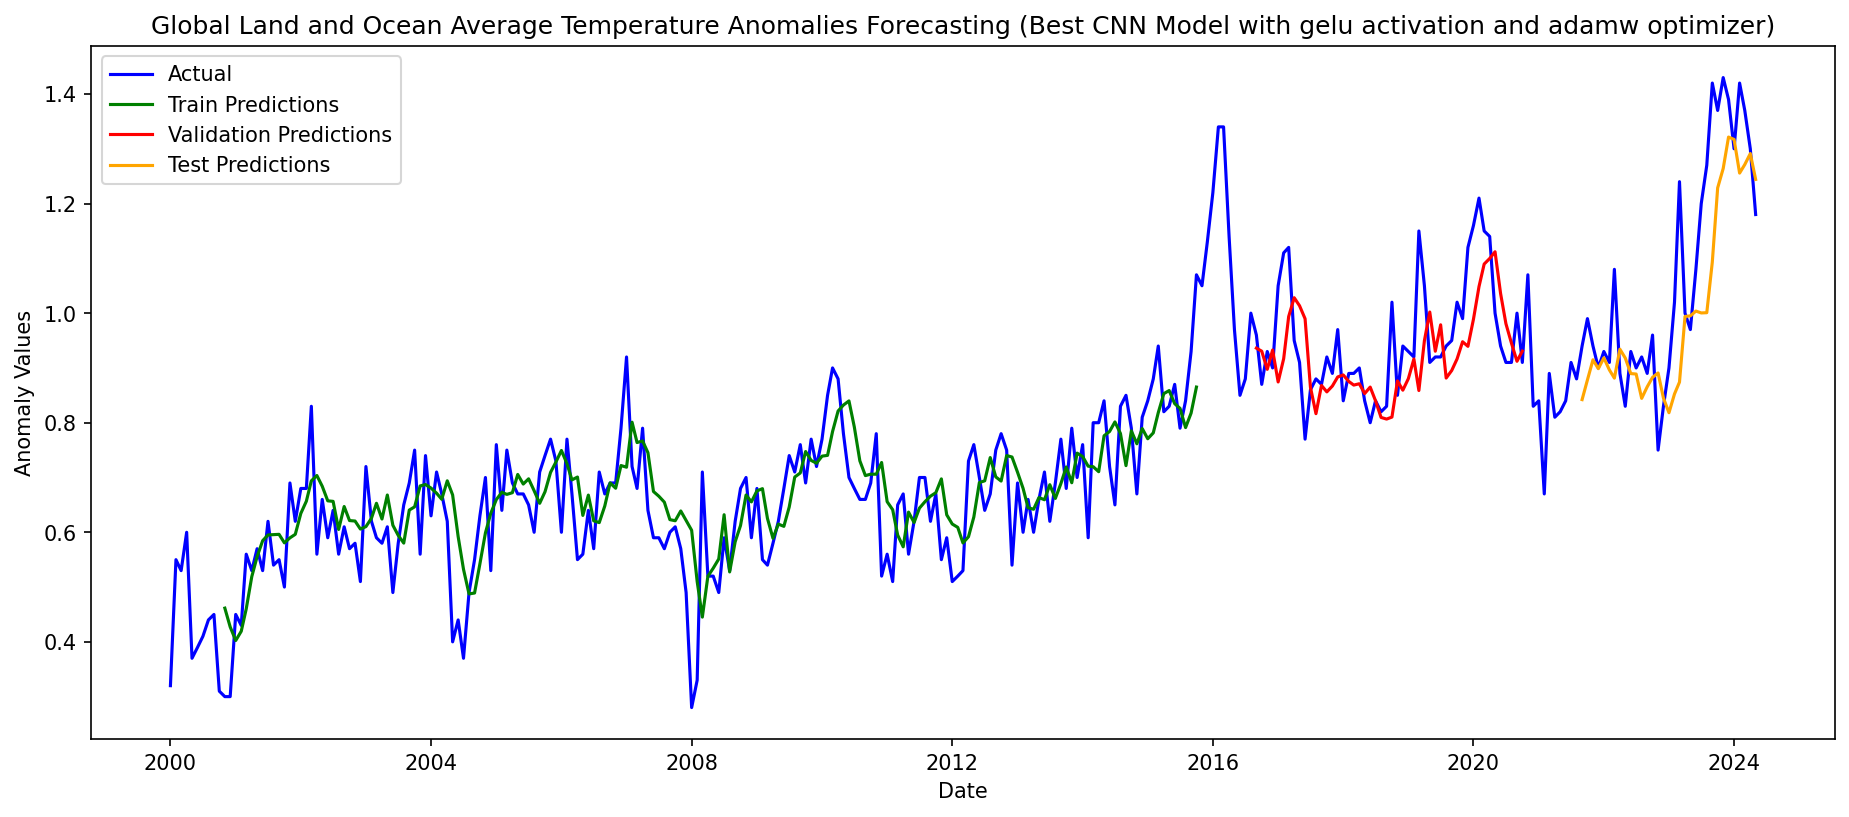

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import sqrt

# Train the final model using the best combination
best_activation, best_optimizer = best_combination
best_model, best_history = create_train_cnn_model_grid_search(best_activation, best_optimizer)

# Evaluate the best model
test_predict_best = best_model.predict(X_test)

# Inverse transform the predictions and actual values
test_predict_best_inv = scaler.inverse_transform(test_predict_best)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics for the best model
best_test_mse = mean_squared_error(y_test_inv, test_predict_best_inv)
best_test_rmse = sqrt(best_test_mse)
best_test_mae = mean_absolute_error(y_test_inv, test_predict_best_inv)
best_test_r2 = r2_score(y_test_inv, test_predict_best_inv)

# Print the metrics for the best model
print("Best Model Performance Metrics:")
print(f"  Test MSE: {best_test_mse:.4f}")
print(f"  Test RMSE: {best_test_rmse:.4f}")
print(f"  Test MAE: {best_test_mae:.4f}")
print(f"  Test R²: {best_test_r2:.4f}")

# Plotting
plt.figure(figsize=(15, 6), dpi=150)

# Plot actual values
plt.plot(df.index, df['Value'], label='Actual', color='blue')

# Generate and plot training predictions for the best model
train_predict_best = best_model.predict(X_train)
train_predict_best_inv = scaler.inverse_transform(train_predict_best)
# Adjust the index for training predictions
plt.plot(df.index[seq_length : len(train) ], train_predict_best_inv.flatten(), label='Train Predictions', color='green')

# Generate and plot validation predictions for the best model
val_predict_best = best_model.predict(X_val)
val_predict_best_inv = scaler.inverse_transform(val_predict_best)
# Adjust the index for validation predictions
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], val_predict_best_inv.flatten(), label='Validation Predictions', color='red')


# Plot test predictions (already calculated)
# Adjust the index for test predictions
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], test_predict_best_inv.flatten(), label='Test Predictions', color='orange')

plt.title(f'Global Land and Ocean Average Temperature Anomalies Forecasting (Best CNN Model with {best_activation} activation and {best_optimizer} optimizer)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values')
plt.legend(loc='upper left')
plt.show()

## Define DeepONet Architecture

### Subtask:
Implement the DeepONet model using TensorFlow/Keras. This will involve defining two sub-networks (branch and trunk) and then combining their outputs. Since the current task is single-step prediction, the trunk network's input will need to be a consistent 'query point' (e.g., a constant vector representing the prediction horizon).

#### Instructions
1. Define the branch network using the Keras functional API. It should take a sequence of `seq_length` historical data points as input. The network should consist of several `Dense` layers with activation functions (e.g., ReLU or the `best_activation` found in the grid search). The output of the branch network should be a feature vector.
2. Define the trunk network, also using the Keras functional API. For single-step prediction, its input should be a placeholder or a constant 'query point' representing the prediction horizon (e.g., a tensor of ones with a shape suitable for the trunk network's input). The network should consist of several `Dense` layers with activation functions, and its output should also be a feature vector of the same dimension as the branch network's output.
3. Combine the outputs of the branch and trunk networks. This typically involves an element-wise multiplication followed by a summation layer (`tf.reduce_sum`) to produce a single scalar output, representing the predicted value.
4. Construct the full DeepONet model using the Keras `Model` class, specifying both the branch and trunk inputs and the combined output.

**Reasoning**:
The first step in implementing DeepONet is to define the branch network, which will process the historical data. This code block will create the branch network using the Keras functional API with Dense layers and the best activation function identified previously.



In [18]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Define the Branch Network
# Input: Sequence of historical data points (seq_length, 1)
branch_input = Input(shape=(seq_length, 1), name='branch_input')

# Flatten the input sequence
branch_flat = Flatten()(branch_input)

# Dense layers for the branch network
branch_output = Dense(128, activation=best_activation)(branch_flat)
branch_output = Dense(128, activation=best_activation)(branch_output)
branch_output = Dense(128, activation=best_activation)(branch_output) # Output feature vector

print("Branch network defined.")

Branch network defined.


**Reasoning**:
Next, define the trunk network, which processes the prediction time point. For single-step prediction, its input should represent the prediction horizon, and its output should be a feature vector of the same dimension as the branch network's output.



In [19]:
feature_vector_dim = 128 # This should match the last Dense layer output of the branch network
trunk_input = Input(shape=(1,), name='trunk_input') # For single-step prediction, input can be a scalar (e.g., 1 for next step)

# Dense layers for the trunk network
trunk_output = Dense(feature_vector_dim, activation=best_activation)(trunk_input)
trunk_output = Dense(feature_vector_dim, activation=best_activation)(trunk_output)
trunk_output = Dense(feature_vector_dim, activation=best_activation)(trunk_output) # Output feature vector

print("Trunk network defined.")

Trunk network defined.


**Reasoning**:
Now that both the branch and trunk networks are defined, the next step is to combine their outputs using element-wise multiplication and summation to produce the final prediction, and then construct the full DeepONet model.



In [20]:
from tensorflow.keras.layers import Lambda, Multiply

# Combine the outputs of the branch and trunk networks
# Element-wise multiplication of feature vectors using a Keras layer
multiplied_features = Multiply()([branch_output, trunk_output])

# Sum along the feature dimension to get a scalar per sample, then expand dims for the Dense layer
# This Lambda layer correctly handles KerasTensors
combined_output = Lambda(lambda x: tf.expand_dims(tf.reduce_sum(x, axis=1), axis=-1))(multiplied_features)

# Output layer for the final prediction (single scalar)
deeponet_output = Dense(1, activation='linear')(combined_output)

# Construct the full DeepONet model
deeponet_model = Model(inputs=[branch_input, trunk_input], outputs=deeponet_output)

# Compile the model
if best_optimizer == 'adam':
    optimizer = optimizers.Adam()
elif best_optimizer == 'adamw':
    optimizer = optimizers.AdamW()
elif best_optimizer == 'adamax':
    optimizer = optimizers.Adamax()
else:
    raise ValueError(f"Unsupported optimizer: {best_optimizer}. Choose from 'adam', 'adamw', or 'adamax'.")

deeponet_model.compile(optimizer=optimizer, loss='mse')

print("DeepONet model constructed and compiled.")

DeepONet model constructed and compiled.


**Reasoning**:
With the DeepONet model architecture defined, the next step is to prepare the input data for the trunk network. For single-step time series prediction, the trunk network typically takes a consistent 'query point' as input, indicating the prediction horizon. I will create an array of ones with the appropriate shape for the trunk input for training, validation, and testing sets.



In [21]:
import numpy as np

# Create trunk input for training, validation, and test sets
# For single-step prediction, this is a consistent 'query point' (e.g., 1 for the next step)
trunk_input_train = np.ones((X_train.shape[0], 1))
trunk_input_val = np.ones((X_val.shape[0], 1))
trunk_input_test = np.ones((X_test.shape[0], 1))

print(f"Trunk input for training created with shape: {trunk_input_train.shape}")
print(f"Trunk input for validation created with shape: {trunk_input_val.shape}")
print(f"Trunk input for testing created with shape: {trunk_input_test.shape}")

Trunk input for training created with shape: (180, 1)
Trunk input for validation created with shape: (50, 1)
Trunk input for testing created with shape: (33, 1)


**Reasoning**:
Now that the DeepONet model architecture is defined and the input data for both the branch and trunk networks (including the `trunk_input` arrays) is prepared, the next step is to train the DeepONet model. This will be used for the `fit` method with `EarlyStopping` for regularization.



In [22]:
early_stopping_deeponet = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

print("Training DeepONet model...")

history_deeponet = deeponet_model.fit(
    [X_train, trunk_input_train],
    y_train,
    validation_data=([X_val, trunk_input_val], y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping_deeponet]
)

print("DeepONet model training complete.")

Training DeepONet model...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.2070 - val_loss: 0.2233
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0516 - val_loss: 0.1444
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0377 - val_loss: 0.0675
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0309 - val_loss: 0.0401
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0190 - val_loss: 0.0236
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0202 - val_loss: 0.0198
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0158 - val_loss: 0.0322
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0167 - val_loss: 0.0154
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0162 - val_loss: 0.0250
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/s

## Evaluate DeepONet Performance

### Subtask:
Calculate and print the performance metrics (Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²)) for the trained DeepONet model on the test data. These metrics will be used to compare its accuracy against previous models.


**Reasoning**:
The next step is to calculate the performance metrics (MSE, RMSE, MAE, and R-squared) for the trained DeepONet model on the test data. This involves making predictions, inverse transforming the data, and then computing the metrics, similar to how the best CNN model was evaluated.



In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import sqrt

# Make predictions on the test data using the trained DeepONet model
deeponet_test_predict = deeponet_model.predict([X_test, trunk_input_test])

# Inverse transform the predictions to the original scale
deeponet_test_predict_inv = scaler.inverse_transform(deeponet_test_predict)

# Inverse transform the actual test values to the original scale
y_test_inv_deeponet = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics for the DeepONet model on the test set
deeponet_test_mse = mean_squared_error(y_test_inv_deeponet, deeponet_test_predict_inv)
deeponet_test_rmse = sqrt(deeponet_test_mse)
deeponet_test_mae = mean_absolute_error(y_test_inv_deeponet, deeponet_test_predict_inv)
deeponet_test_r2 = r2_score(y_test_inv_deeponet, deeponet_test_predict_inv)

# Print the performance metrics
print("DeepONet Model Performance Metrics on Test Data:")
print(f"  Test MSE: {deeponet_test_mse:.4f}")
print(f"  Test RMSE: {deeponet_test_rmse:.4f}")
print(f"  Test MAE: {deeponet_test_mae:.4f}")
print(f"  Test R\u00b2: {deeponet_test_r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
DeepONet Model Performance Metrics on Test Data:
  Test MSE: 0.0125
  Test RMSE: 0.1118
  Test MAE: 0.0883
  Test R²: 0.7023


## Visualize DeepONet Predictions

### Subtask:
Create a plot showing the actual temperature anomaly values from the test set against the DeepONet's predicted values, providing a visual comparison of its forecasting ability.


**Reasoning**:
To visualize the DeepONet's forecasting ability, I will create a plot comparing the actual temperature anomaly values from the test set with the model's predicted values.



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


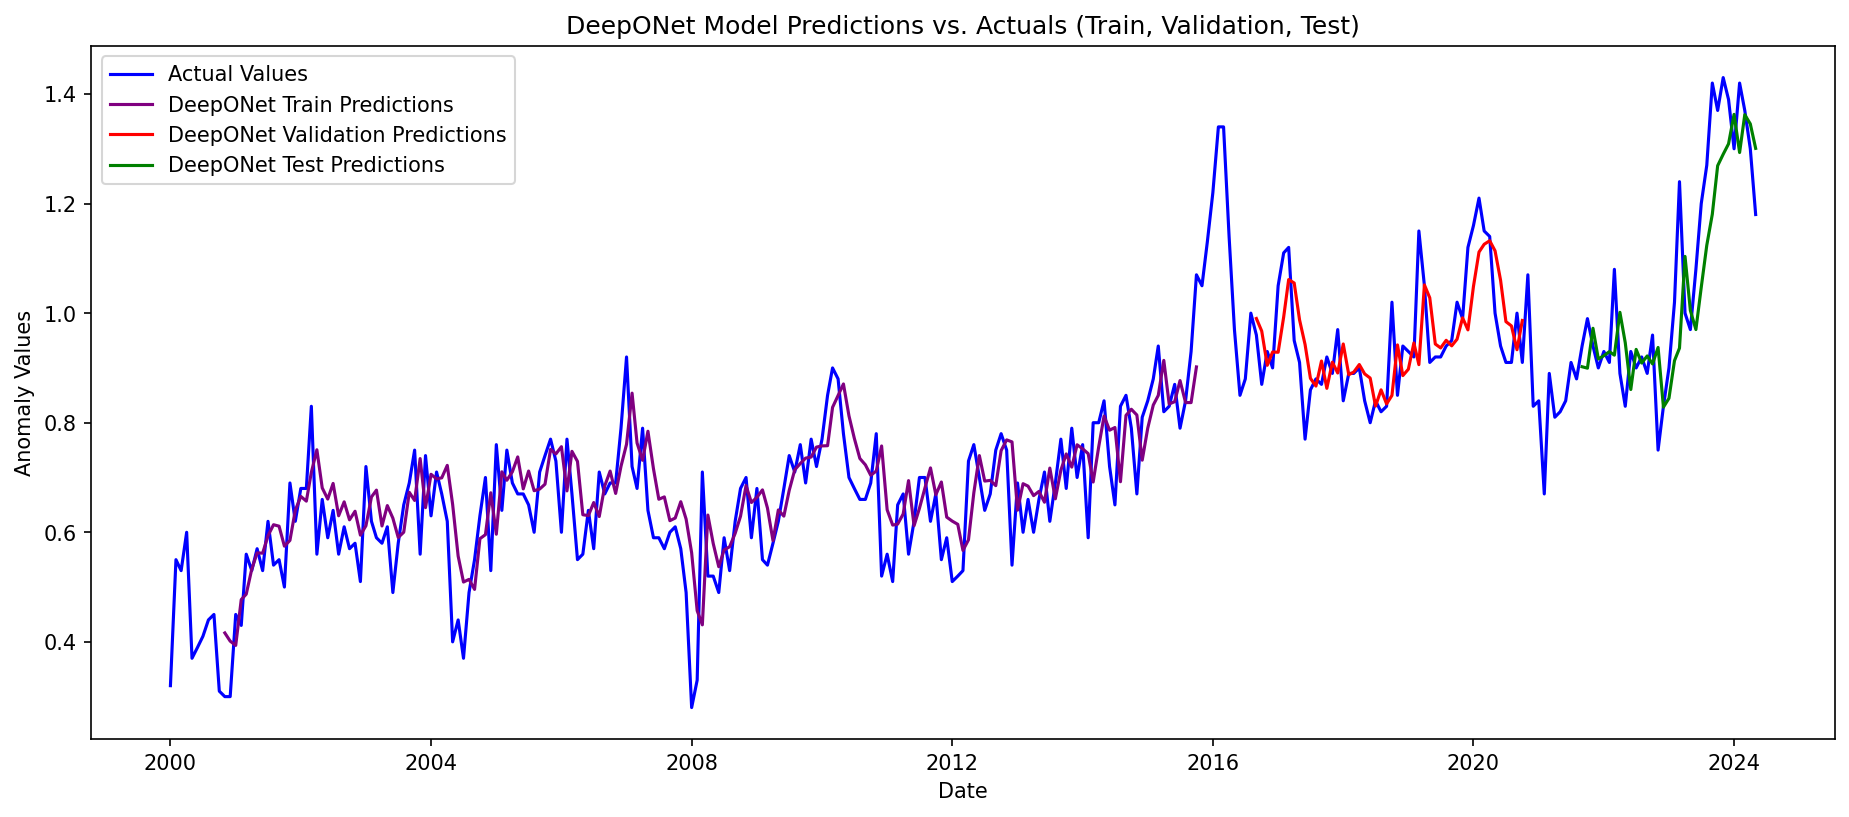

In [24]:
import matplotlib.pyplot as plt

# Create a figure and axes object for the plot
plt.figure(figsize=(15, 6), dpi=150)

# Plot actual values from the original DataFrame
plt.plot(df.index, df['Value'], label='Actual Values', color='blue')

# Generate and plot training predictions for the DeepONet model
deeponet_train_predict = deeponet_model.predict([X_train, trunk_input_train])
deeponet_train_predict_inv = scaler.inverse_transform(deeponet_train_predict)
# Adjust the index for training predictions
plt.plot(df.index[seq_length : len(train)], deeponet_train_predict_inv.flatten(), label='DeepONet Train Predictions', color='purple')

# Generate and plot validation predictions for the DeepONet model
deeponet_val_predict = deeponet_model.predict([X_val, trunk_input_val])
deeponet_val_predict_inv = scaler.inverse_transform(deeponet_val_predict)
# Adjust the index for validation predictions
plt.plot(df.index[len(train) + seq_length : len(train) + len(valid)], deeponet_val_predict_inv.flatten(), label='DeepONet Validation Predictions', color='red')

# Plot DeepONet's predicted values on the test set (already calculated)
# Adjust the index for test predictions
plt.plot(df.index[len(train) + len(valid) + seq_length : len(df)], deeponet_test_predict_inv.flatten(), label='DeepONet Test Predictions', color='green')

# Add title and labels
plt.title('DeepONet Model Predictions vs. Actuals (Train, Validation, Test)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values')

# Add legend
plt.legend(loc='upper left')

# Display the plot
plt.show()

## DeepONet vs. Best CNN Model: Performance Comparison

To provide a clearer comparison of the DeepONet model against the previously identified best CNN model, here are their performance metrics on the test data presented side-by-side.

In [25]:
print("\n--- Model Performance Comparison (Test Data) ---")
print("\nMetric      | DeepONet      | Best CNN Model")
print("---------------------------------------------------")
print(f"MSE         | {deeponet_test_mse:.4f}        | {best_test_mse:.4f}")
print(f"RMSE        | {deeponet_test_rmse:.4f}        | {best_test_rmse:.4f}")
print(f"MAE         | {deeponet_test_mae:.4f}        | {best_test_mae:.4f}")
print(f"R\u00b2          | {deeponet_test_r2:.4f}        | {best_test_r2:.4f}")
print("---------------------------------------------------")


--- Model Performance Comparison (Test Data) ---

Metric      | DeepONet      | Best CNN Model
---------------------------------------------------
MSE         | 0.0125        | 0.0180
RMSE        | 0.1118        | 0.1341
MAE         | 0.0883        | 0.0977
R²          | 0.7023        | 0.5717
---------------------------------------------------
